In [1]:
import pandas as pd
import psycopg2
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [ ]:
df = pd.read_csv('job_dataset.csv')

con = psycopg2.connect(database="jobsdb", user="postgres", password="12345", host="127.0.0.1", port="5432")
cur = con.cursor()
print("Connected to PostgreSQL.")

create_sql = """
CREATE TABLE IF NOT EXISTS job_postings (
    JobID VARCHAR PRIMARY KEY,
    Title TEXT,
    ExperienceLevel TEXT,
    YearsOfExperience TEXT,
    Skills TEXT,
    Responsibilities TEXT,
    Keywords TEXT
);
"""
cur.execute(create_sql)
con.commit()

insert_sql = """
INSERT INTO job_postings (JobID, Title, ExperienceLevel, YearsOfExperience, Skills, Responsibilities, Keywords)
VALUES (%s, %s, %s, %s, %s, %s, %s)
ON CONFLICT (JobID) DO NOTHING;
"""
for _, row in df.iterrows():
    cur.execute(insert_sql, (
        row['JobID'], row['Title'], row['ExperienceLevel'], row['YearsOfExperience'],
        row['Skills'], row['Responsibilities'], row['Keywords']
    ))
con.commit()
print("Data inserted into job_postings table.")


Connected to PostgreSQL.
Data inserted into job_postings table.


In [4]:
# count of job posts by Title
cur.execute("SELECT Title, COUNT(*) FROM job_postings GROUP BY Title;")
results = cur.fetchall()
for title, count in results[:5]:
    print(f"{title}: {count} postings")

Trainee iOS Developer: 1 postings
Senior System Engineer: 1 postings
Senior Machine Learning Engineer: 2 postings
Data Analyst - Experienced: 11 postings
BI Analyst - Experienced: 11 postings


In [5]:
X_resp = df['Responsibilities']
y_title = df['Title']

X_train, X_test, y_train, y_test = train_test_split(X_resp, y_title, test_size=0.2, random_state=42)

pipe = make_pipeline(TfidfVectorizer(stop_words='english'), MultinomialNB())
pipe.fit(X_train, y_train)

pred_titles = pipe.predict(X_test)
print("Title prediction accuracy:", accuracy_score(y_test, pred_titles))

Title prediction accuracy: 0.5280373831775701


In [ ]:
# add a column for predicted title
cur.execute("ALTER TABLE job_postings ADD COLUMN pred_title TEXT;")
for idx, jobid in enumerate(X_test.index):
    cur.execute("UPDATE job_postings SET pred_title = %s WHERE JobID = %s;",
                (pred_titles[idx], df.loc[jobid, 'JobID']))
con.commit()
print("Predicted titles saved to database.")

Predicted titles saved to database.


In [7]:
skills_list = df['Skills'].str.split(';').apply(lambda xs: [s.strip() for s in xs])  # list of skills
mlb = MultiLabelBinarizer()
Y_skills = mlb.fit_transform(skills_list)  # binary matrix of skills
X_text = df['Title'] + " " + df['Responsibilities']

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_text, Y_skills, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X_train_vec = vectorizer.fit_transform(X_train2)

clf = OneVsRestClassifier(LogisticRegression(max_iter=1000))
clf.fit(X_train_vec, y_train2)

X_test_vec = vectorizer.transform(X_test2)
y_pred2 = clf.predict(X_test_vec)

from sklearn.metrics import f1_score
print("Skill prediction F1 score:", f1_score(y_test2, y_pred2, average='samples'))

c:\Users\Maxim\miniconda3\Lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 14 is present in all training examples.
  warnings.warn(
c:\Users\Maxim\miniconda3\Lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 23 is present in all training examples.
  warnings.warn(
c:\Users\Maxim\miniconda3\Lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 29 is present in all training examples.
  warnings.warn(
c:\Users\Maxim\miniconda3\Lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 51 is present in all training examples.
  warnings.warn(
c:\Users\Maxim\miniconda3\Lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 74 is present in all training examples.
  warnings.warn(
c:\Users\Maxim\miniconda3\Lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 90 is present in all training examples.
  warnings.warn(
c:\Users\Maxim\miniconda3\Lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 95 is p

Skill prediction F1 score: 0.12186372028416288


In [ ]:
cur.execute("ALTER TABLE job_postings ADD COLUMN pred_skills TEXT;")
for idx, jobid in enumerate(X_test2.index):
    pred_skills = mlb.inverse_transform(y_pred2[idx].reshape(1, -1))[0]
    cur.execute("UPDATE job_postings SET pred_skills = %s WHERE JobID = %s;",
                (", ".join(pred_skills), df.loc[jobid, 'JobID']))
con.commit()
print("Predicted skills saved to database")


Predicted skills saved to database


In [ ]:
X_resp_tfidf = TfidfVectorizer(stop_words='english', max_features=500).fit_transform(df['Responsibilities'])
kmeans_resp = KMeans(n_clusters=4, random_state=0).fit(X_resp_tfidf)
resp_clusters = kmeans_resp.labels_

cur.execute("ALTER TABLE job_postings ADD COLUMN resp_cluster INT;")
for jobid, label in zip(df['JobID'], resp_clusters):
    cur.execute("UPDATE job_postings SET resp_cluster = %s WHERE JobID = %s;", (int(label), jobid))
con.commit()
print("Responsibilities clusters counts:", dict(pd.Series(resp_clusters).value_counts()))


Responsibilities clusters counts: {1: np.int64(431), 3: np.int64(356), 2: np.int64(163), 0: np.int64(118)}


In [ ]:
kmeans_skills = KMeans(n_clusters=3, random_state=0).fit(Y_skills)
skill_clusters = kmeans_skills.labels_
cur.execute("ALTER TABLE job_postings ADD COLUMN skills_cluster INT;")
for jobid, label in zip(df['JobID'], skill_clusters):
    cur.execute("UPDATE job_postings SET skills_cluster = %s WHERE JobID = %s;", (int(label), jobid))
con.commit()
print("Skills clusters counts:", dict(pd.Series(skill_clusters).value_counts()))


Skills clusters counts: {2: np.int64(814), 1: np.int64(224), 0: np.int64(30)}


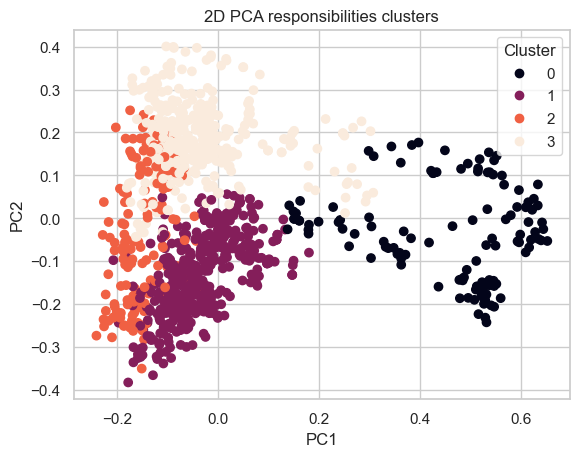

In [11]:
df['resp_cluster'] = resp_clusters
df['skills_cluster'] = skill_clusters
sns.set_theme(style="whitegrid")

pca = PCA(n_components=2, random_state=0)
X_resp_2d = pca.fit_transform(X_resp_tfidf)

plt.figure()
scatter = plt.scatter(X_resp_2d[:, 0], X_resp_2d[:, 1], c=df['resp_cluster'])
plt.title("2D PCA responsibilities clusters")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()


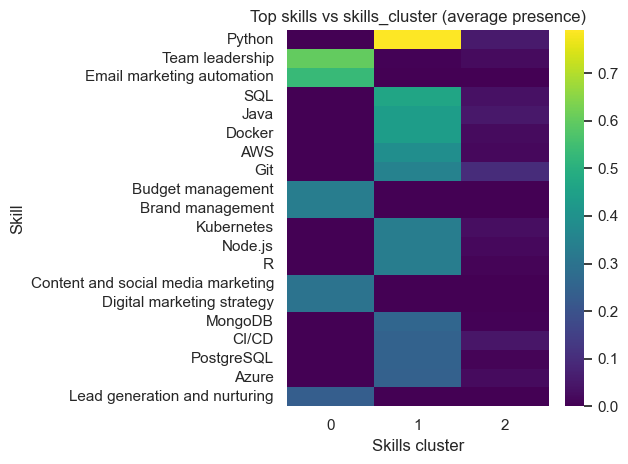

In [12]:
skills_df = pd.DataFrame(Y_skills, columns=mlb.classes_)
cluster_skill_means = skills_df.groupby(df['skills_cluster']).mean().T  # skills x clusters
top_skills = cluster_skill_means.max(axis=1).sort_values(ascending=False).head(20).index
cluster_skill_means_top = cluster_skill_means.loc[top_skills]

plt.figure()
sns.heatmap(cluster_skill_means_top, annot=False, cmap="viridis")
plt.title("Top skills vs skills_cluster (average presence)")
plt.xlabel("Skills cluster")
plt.ylabel("Skill")
plt.tight_layout()
plt.show()


In [4]:
con = psycopg2.connect(database="jobsdb", user="postgres", password="12345", host="127.0.0.1", port="5432")
cur = con.cursor()
query = """
SELECT
    TRIM(skill) AS skill,
    COUNT(*) AS cnt
FROM job_postings
CROSS JOIN UNNEST(string_to_array(Skills, ';')) AS skill
GROUP BY TRIM(skill)
ORDER BY cnt DESC
LIMIT 20;
"""

cur.execute(query)
rows = cur.fetchall()
print("Top 20 skills:")
for skill, cnt in rows:
    print(f"{skill} {cnt}")


Top 20 skills:
Python 213
Communication 167
Leadership 150
Problem-solving 143
Java 140
Git 127
SQL 124
Python basics 123
AWS 101
Docker 100
Teamwork 95
Collaboration 87
Project management 84
CI/CD 82
R 80
Kubernetes 79
Tableau 79
Python advanced 76
Figma 72
Azure 71


In [3]:
query = """
WITH skill_counts AS (
    SELECT
        skills_cluster,
        TRIM(skill) AS skill,
        COUNT(*) AS cnt
    FROM job_postings
    CROSS JOIN UNNEST(string_to_array(Skills, ';')) AS skill
    GROUP BY skills_cluster, TRIM(skill)
),
ranked AS (
    SELECT
        skills_cluster,
        skill,
        cnt,
        ROW_NUMBER() OVER (
            PARTITION BY skills_cluster
            ORDER BY cnt DESC
        ) AS rn
    FROM skill_counts
)
SELECT skills_cluster, skill, cnt
FROM ranked
WHERE rn <= 5
ORDER BY skills_cluster, cnt DESC;
"""

cur.execute(query)
rows = cur.fetchall()
print("Top 5 skills per skills_cluster:")
for cluster, skill, cnt in rows:
    print(f"Cluster {cluster}: {skill} {cnt}")


Top 5 skills per skills_cluster:
Cluster 0: Team leadership 18
Cluster 0: Email marketing automation 16
Cluster 0: Budget management 10
Cluster 0: Brand management 10
Cluster 0: Digital marketing strategy 9
Cluster 1: Python 170
Cluster 1: Java 98
Cluster 1: SQL 94
Cluster 1: AWS 87
Cluster 1: Docker 82
Cluster 2: Communication 166
Cluster 2: Problem-solving 132
Cluster 2: Leadership 124
Cluster 2: Python basics 123
Cluster 2: Teamwork 92


In [5]:
query = """
SELECT skills_cluster, ExperienceLevel, COUNT(*) AS cnt
FROM job_postings
GROUP BY skills_cluster, ExperienceLevel
ORDER BY skills_cluster, cnt DESC;
"""

cur.execute(query)
rows = cur.fetchall()
print("Experience level distribution per skills_cluster:")
for cluster, level, cnt in rows:
    print(f"Cluster {cluster}|{level}|{cnt}")

cur.close()
con.close()

Experience level distribution per skills_cluster:
Cluster 0|Experienced|30
Cluster 1|Experienced|92
Cluster 1|Fresher|42
Cluster 1|Senior-Level|27
Cluster 1|Entry-Level|21
Cluster 1|Senior|12
Cluster 1|Mid-Senior Level|2
Cluster 1|Mid-Senior|1
Cluster 2|Experienced|343
Cluster 2|Fresher|302
Cluster 2|Mid-Level|60
Cluster 2|Entry-Level|45
Cluster 2|Senior-Level|39
Cluster 2|Lead|7
Cluster 2|Junior|5
Cluster 2|Mid-level|5
Cluster 2|Senior|3
Cluster 2|Mid-Senior|1
Cluster 2|Mid-Senior Level|1
